# Multimodal RAG

- Author: [Kane](https://github.com/HarryKane11)
- Design: [Kane](https://github.com/HarryKane11)
- Peer Review : [Mark](https://github.com/obov), [Brian](https://github.com/brian604)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

## Overview

This tutorial demonstrates how to build a Multimodal RAG (Retrieval-Augmented Generation) system using LangChain. The system processes both text and images from documents, creating a unified knowledge base for question-answering.

Key features include:
- Text content extraction to markdown using pymupdf4llm
- Image content extraction using Upstage Document AI API
- Text and image content merging by page
- RAG implementation using OpenAI embeddings and GPT-4o
- Langgraph based RAG pipeline

![Multimodal RAG Architecture](assets/Multimodal%20RAG%20Architecture.png)

### Table of Contents

- [Environment Setup](#environment-setup)
- [Text Processing](#extract-and-preprocess-text-contents-from-pdf-using-pymupdf4llm)
- [Image Processing](#layout-parsing-to-extract-image-from-pdf-using-upstage-document-parse-api)
- [Multimodal RAG graph Implementation](#building-a-rag-pipeline-with-langgraph)

### References

- [PyMuPDF4LLM](https://pymupdf.readthedocs.io/en/latest/pymupdf4llm/api.html#pymupdf4llm-api)
- [Upstage Document AI](https://www.upstage.ai/blog/en/let-llms-read-your-documents-with-speed-and-accuracy)
- [Gemini in Langchain](https://python.langchain.com/docs/integrations/chat/google_generative_ai/)
- [Multimodal input in Langchain](https://python.langchain.com/docs/how_to/multimodal_inputs/)

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [2]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [1]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "pymupdf4llm",
        "langchain-upstage",
        "langchain-google-genai",
        "langchain-chroma",
        "langchain-openai",       
    ],
    verbose=False,
    upgrade=False,
)

In [37]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "GOOGLE_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "06-Multimodal",
        "UPSTAGE_API_KEY": ""
    }
)

Environment variables have been set successfully.


In [32]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Extract and preprocess Text contents from PDF using PyMuPDF4LLM
### PyMuPDF4LLM

PyMuPDF4LLM is a Python package designed to facilitate the extraction of PDF content into formats suitable for Large Language Models (LLMs) and Retrieval-Augmented Generation (RAG) environments. It supports Markdown extraction and LlamaIndex document output, making it a valuable tool for developing document-based AI applications.

### Key Features

- **Multi-Column Page Support**: Accurately extracts text from pages with multiple columns.

- **Image and Vector Graphics Extraction**: Extracts images and vector graphics from pages, including references in the Markdown text.

- **Page Chunking Output**: Outputs pages in chunks, facilitating use in LLM and RAG systems.

- **LlamaIndex Document Output**: Directly converts PDFs into LlamaIndex document format.

In [1]:
# Install PyMuPDF4LLM using pip:
# %pip install pymupdf4llm

In [11]:
import pymupdf4llm

file_path = "data/BCG-ai-maturity-matrix-nov-2024.pdf"

# to_markdown() function extracts text content and converts it into markdown format
md_text = pymupdf4llm.to_markdown(
    doc=file_path,  # The file, either as a file path or a PyMuPDF Document.
    page_chunks=True,  # If True, output is a list of page-specific dictionaries.
    show_progress=True  # Displays a progress bar during processing.
    # pages=[0, 1, 2],  - Optional, specify 0-based page numbers to process.
    # hdr_info=False,  - Optional, disables header detection logic.
    # write_images=True,  - Saves images found in the document as files.
    # embed_images=True,  - Embeds images directly as base64 in markdown.
    # image_size_limit=0.05,  - Exclude small images below this size threshold.
    # dpi=150,  - Image resolution in dots per inch, if write_images=True.
    # image_path="output_images",  - Directory to save images if write_images=True.
    # image_format="png",  - Image file format, e.g., "png" or "jpg".
    # force_text=True,  - Include text overlapping images/graphics.
    # margins=0,  - Specify page margins for text extraction.
    # page_width=612,  - Desired page width for reflowable documents.
    # page_height=None,  - Desired page height for reflowable documents.
    # table_strategy="lines_strict",  - Strategy for table detection.
    # graphics_limit=5000,  - Limit the number of vector graphics processed.
    # ignore_code=False,  - If True, avoids special formatting for mono-spaced text.
    # extract_words=False,  - Adds word-level data to each page dictionary.
)


Processing data/BCG-ai-maturity-matrix-nov-2024.pdf...
[                                        ] (0/2[=                                       ] ( 1/2=[===                                     ] ( 2/2=[=====                                   ] ( 3/2[======                                  ] ( 4/23=[========                                ] ( 5/23=[==========                              ] ( 6/23=[============                            ] ( 7/23[=============                           ] ( 8/2=[===============                         ] ( 9/2=[=================                       ] (10/2=[===================                     ] (11/2[====================                    ] (12/23=[======================                  ] (13/23=[========================                ] (14/23=[==========================              ] (15/23[===========================             ] (16/2=[=============================           ] (17/2=[===============================         ] (18/2=[===========

In [12]:
md_text[0]

{'metadata': {'format': 'PDF 1.4',
  'title': '',
  'author': '',
  'subject': '',
  'keywords': '',
  'creator': 'Adobe InDesign 19.5 (Macintosh)',
  'producer': 'Adobe PDF Library 17.0',
  'creationDate': "D:20241115111150-06'00'",
  'modDate': "D:20241115111159-06'00'",
  'trapped': '',
  'encryption': None,
  'file_path': 'data/BCG-ai-maturity-matrix-nov-2024.pdf',
  'page_count': 23,
  'page': 1},
 'toc_items': [],
 'tables': [],
 'images': [{'number': 0,
   'bbox': Rect(0.0, 50.0, 595.2760009765625, 791.8900146484375),
   'transform': (597.5172729492188,
    0.0,
    -0.0,
    844.1083374023438,
    -1.0398268699645996,
    -1.1094970703125),
   'width': 2789,
   'height': 3940,
   'colorspace': 3,
   'cs-name': 'ICCBased(RGB,Adobe RGB (1998))',
   'xres': 96,
   'yres': 96,
   'bpc': 8,
   'size': 3307487}],
 'graphics': [],
 'text': '## The AI Maturity Matrix \n\n###### Which Economies Are Ready for AI?\n\nNovember 2024\nBy Christian Schwaerzler, Miguel Carrasco, Christopher Da

In [13]:
for i, j in enumerate(md_text[:3]):
    print(f"page {i+1}: {j['text'][:500]}")

page 1: ## The AI Maturity Matrix 

###### Which Economies Are Ready for AI?

November 2024
By Christian Schwaerzler, Miguel Carrasco, Christopher Daniel,
Brooke Bollyky, Yoshihisa Niwa, Aparna Bharadwaj, Akram Awad,
Richard Sargeant, Sanjay Nawandhar, and Svetlana Kostikova


-----


page 2: ### Contents

#### 03 Introduction

 04 Key Findings

 05 The Relationship Between
 Exposure and Readiness

 10 The Archetypes of AI Adoption

 15 Strategic Next Steps

 17 Methodology

 21 About the Authors


-----


page 3: ### Introduction

iews vary on how much AI is changing the world
today, but one thing is clear: the technology is on
course to shape the future of economic development.

# V

Business leaders expect large impacts on operations and
value creation in the 3-to-10-year timeframe, and world­
wide spending on artificial intelligence will more than
double to $632 billion by 2028.[1] The long-term, expansive
scale of this growth makes AI an economic priority in every
region acro

## Layout parsing to extract image from PDF using Upstage Document Parse API

The Upstage Document Parse API is a robust AI model that converts various document formats, including PDFs and images, into HTML by detecting layout elements such as paragraphs, tables, and images. This facilitates the integration of document content into applications requiring structured data.

**Key Features:**

- **Layout Detection:** Identifies and preserves document structures, including paragraphs, tables, and images.

- **Format Conversion:** Transforms documents into HTML, maintaining the original layout and reading order.

- **High Performance:** Processes documents swiftly, handling up to 100 pages per minute.
  
<img src="https://cdn.prod.website-files.com/6743d5190bb2b52f38e99ecd/674803bdd33f606f35b972bf_Upstage_DP_KV.png" alt="image" width="700">

Source: [Upstage Official Website](https://www.upstage.ai/blog/en/let-llms-read-your-documents-with-speed-and-accuracy)


### UpstageDocumentParseLoader in LangChain
The UpstageDocumentParseLoader is a component of the langchain_upstage package that integrates Upstage's Document Parser API into the LangChain framework. It enables seamless loading and parsing of documents within LangChain applications. 


In [10]:
# Install the langchain-upstage package using pip:
# pip install -U langchain-upstage

In [14]:
from langchain_upstage import UpstageDocumentParseLoader

loader = UpstageDocumentParseLoader(
            file_path, split="page", 
            output_format="markdown",
            base64_encoding=["figure", "chart", "table"]
         )
docs = loader.load_and_split()

In [15]:
len(docs)

25

Inspect parsed documents to check for and display base64-encoded content along with a brief summary of each document's content and metadata.


In [19]:
for i, j in enumerate(docs[:5]):
    bs_encoding = j.metadata['base64_encodings']

    if len(bs_encoding) > 0:
        print(f"📄 **Page {i+1}**\n{'='*20}")
        print(f"📝 **Page Content Preview:** {j.page_content[:100]}...")
        print(f"🔑 **Metadata Keys:** {', '.join(j.metadata.keys())}")
        print(f"🖼️ **Base64 Encoding (Preview):** {bs_encoding[0][:10]}...")
        print("\n")

📄 **Page 3**
📝 **Page Content Preview:** ![image](/image/placeholder)
 # Introduction Views but one thing is clear: the technology is on
vary...
🔑 **Metadata Keys:** page, base64_encodings, coordinates
🖼️ **Base64 Encoding (Preview):** /9j/2wCEAA...


📄 **Page 4**
📝 **Page Content Preview:** # Key Findings Out of 73 economies assessed, only
five—Canada, Mainland China,
Singapore, the UK, an...
🔑 **Metadata Keys:** page, base64_encodings, coordinates
🖼️ **Base64 Encoding (Preview):** /9j/2wCEAA...


📄 **Page 5**
📝 **Page Content Preview:** ![image](/image/placeholder)
 # The Relationship Between Exposure
and Readiness The adoption is alre...
🔑 **Metadata Keys:** page, base64_encodings, coordinates
🖼️ **Base64 Encoding (Preview):** /9j/2wCEAA...




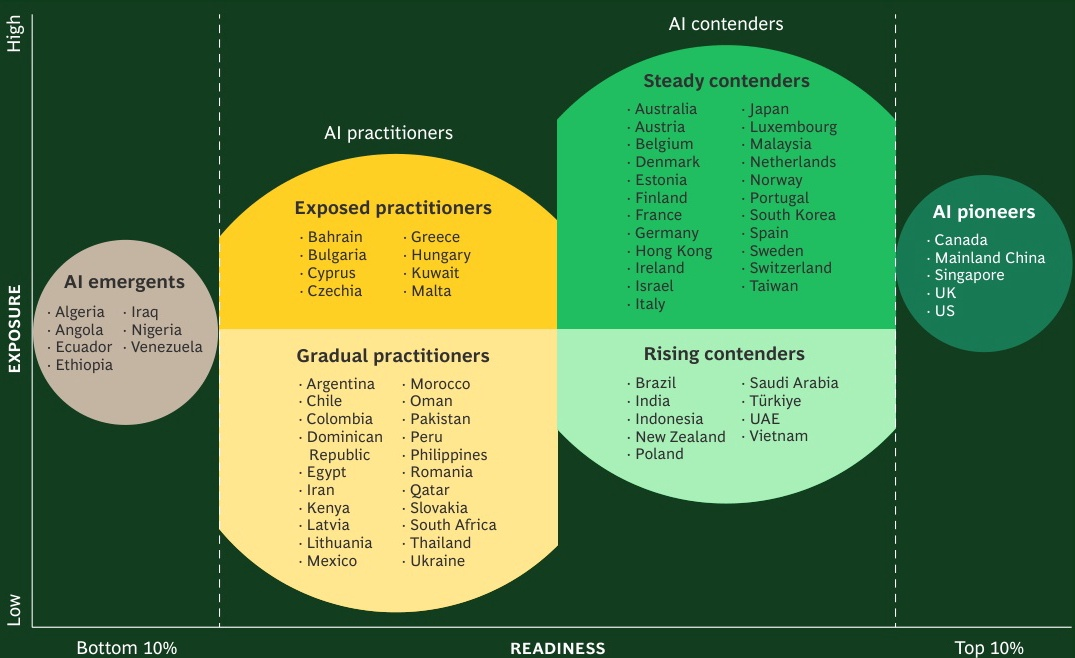

In [20]:
import base64
from IPython.display import Image, display

img_data = base64.b64decode(docs[3].metadata['base64_encodings'][0])  # Decode base64
display(Image(data=img_data))  # Display the image

This process generates multimodal descriptions of images detected on each page using the Gemini 1.5 Flash 8B API. These descriptions are combined with the previously extracted text to create a complete embedding, enabling a RAG pipeline capable of understanding images as well.

In [21]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.documents import Document
import base64

def create_image_descriptions(docs):
    # Initialize the Gemini model
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")
    
    new_documents = []
    
    for doc in docs:
        # Check if base64_encodings exist in metadata
        if 'base64_encodings' in doc.metadata and len(doc.metadata['base64_encodings']) > 0:
            for idx, img_base64 in enumerate(doc.metadata['base64_encodings']):
                # Create a message containing the image
                message = HumanMessage(
                    content=[
                        {"type": "text", 
                         "text": """
                                    Describe only the factual content visible in the image:

                                    1. If decorative/non-informational: output '<---image--->'

                                    2. For content images:
                                    - General Images: List visible objects, text, and measurable attributes
                                    - Charts/Infographics: State all numerical values and labels present
                                    - Tables: Convert to markdown table format with exact data

                                    Rules:
                                    * Include only directly observable information
                                    * Use original numbers and text without modification
                                    * Avoid any interpretation or analysis
                                    * Preserve all labels and measurements exactly as shown
                                """
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                        },
                    ]
                )
                
                # Obtain image description from the model
                response = model.invoke([message])
                
                # Create a new Document
                new_doc = Document(
                    page_content=response.content,
                    metadata={
                        "page": f"{doc.metadata.get('page', 'unknown')}"
                    }
                )
                
                new_documents.append(new_doc)
    
    return new_documents

In [22]:
# Generate image description documents from existing documents
image_description_docs = create_image_descriptions(docs)

# Check the results
for doc in image_description_docs:
    print(f"Page: {doc.metadata['page']}")
    print(f"Description: {doc.page_content}")
    print("---")

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: htt

Page: 3
Description: <---image--->
---
Page: 4
Description: - **Al emergents:** Algeria, Angola, Ecuador, Ethiopia, Iraq, Nigeria, Venezuela
- **Exposed practitioners:** Bahrain, Bulgaria, Cyprus, Czechia, Greece, Hungary, Kuwait, Malta
- **Gradual practitioners:** Argentina, Chile, Colombia, Dominican Republic, Egypt, Iran, Kenya, Latvia, Lithuania, Mexico, Morocco, Oman, Pakistan, Peru, Philippines, Qatar, Romania, Slovakia, South Africa, Thailand, Ukraine
- **Steady contenders:** Australia, Austria, Belgium, Denmark, Estonia, Finland, France, Germany, Hong Kong, Ireland, Israel, Italy, Japan, Luxembourg, Malaysia, Netherlands, Norway, Portugal, South Korea, Spain, Sweden, Switzerland, Taiwan
- **Rising contenders:** Brazil, India, Indonesia, New Zealand, Poland, Saudi Arabia, Türkiye, UAE, Vietnam
- **Al pioneers:** Canada, Mainland China, Singapore, UK, US
- **Exposure:** Low, High
- **Readiness:** Bottom 10%, Top 10%
---
Page: 5
Description: <---image--->
---
Page: 6
Description: 

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: htt

In [23]:
from langchain_core.documents import Document
from collections import defaultdict

def merge_text_and_images(md_text, image_description_docs):
    # Create a dictionary to collect data by page
    page_contents = defaultdict(list)
    page_metadata = {}
    
    # Process md_text
    for text_item in md_text:
        # Standardize page numbers to integer
        page = int(text_item['metadata']['page'])
        page_contents[page].append(text_item['text'])
        # Save metadata for each page
        if page not in page_metadata:
            page_metadata[page] = {
                'source': text_item['metadata']['file_path'],
                'page': page
            }
    
    # Process image_description_docs
    for img_doc in image_description_docs:
        # Standardize page numbers to integer
        page = int(img_doc.metadata['page'])
        page_contents[page].append(img_doc.page_content)
    
    # Create the final list of Document objects
    merged_docs = []
    for page in sorted(page_contents.keys()):
        # Combine all content of the page into a single string
        full_content = '\n\n'.join(page_contents[page])
        
        # Create a Document object
        doc = Document(
            page_content=full_content,
            metadata=page_metadata[page]
        )
        merged_docs.append(doc)
    
    return merged_docs

In [24]:
merged_documents = merge_text_and_images(md_text, image_description_docs)

In [29]:
print(merged_documents[3].page_content)

###### y g

**Out of 73 economies assessed, only**
**five—Canada, Mainland China,**
**Singapore, the UK, and the US—**
**are categorized as AI pioneers.**
They have reached a high level of
readiness by blending elements like
investment and infrastructure, turning
disruption into a competitive edge.
They are in a unique position to guide
the world forward in innovation,
talent development, and AI regulation
and ethics.


**Several economies with high**
**AI readiness are just behind the**
**pace of AI pioneers. While this**
group of AI contenders includes
established economies, it also
features emerging ones like India,
Saudi Arabia, and the UAE that are
using policy and targeted investments
to adopt AI on an advanced level. As
these economies strengthen their
innovation capabilities, they will grow
more competitive and influential in
the AI space.


**Most economies in the study are**
**not ready for AI disruption. More**
**than 70% score below the halfway**
**mark in categories like e

## Building a RAG Pipeline with LangGraph

This guide demonstrates how to use LangGraph to build a unified RAG (Retrieval-Augmented Generation) application. By combining retrieval and generation into a single flow, LangGraph offers streamlined execution, deployment, and additional features like persistence and human-in-the-loop approval.

### Key Components

1. **Application State**:
   - Tracks input (`question`), intermediate (`context`), and output (`answer`) data using a `TypedDict`.

2. **Application Steps**:
   - **Retrieve**: Uses `Chroma` for similarity-based document retrieval.
   - **Generate**: Formats retrieved context and question, then invokes `ChatOpenAI` to generate an answer.

3. **Control Flow**:
   - Uses `StateGraph` to define the sequence and connections between steps.

In [30]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(merged_documents)

In [33]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = Chroma.from_documents(
    documents=all_splits,
    embedding=embeddings
    )

In [34]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

llm = ChatOpenAI(model="gpt-4o")
# Define prompt for question-answering
prompt = ChatPromptTemplate([
    ("human", """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Question: {question} 
Context: {context} 
Answer:
""")])


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [36]:
response = graph.invoke({"question": "Please list AI pioneers"})
print(response["answer"])

The AI pioneers, as mentioned in the context, are Canada, Mainland China, Singapore, the UK, and the US.


As shown in the image below, the answer was correctly predicted.

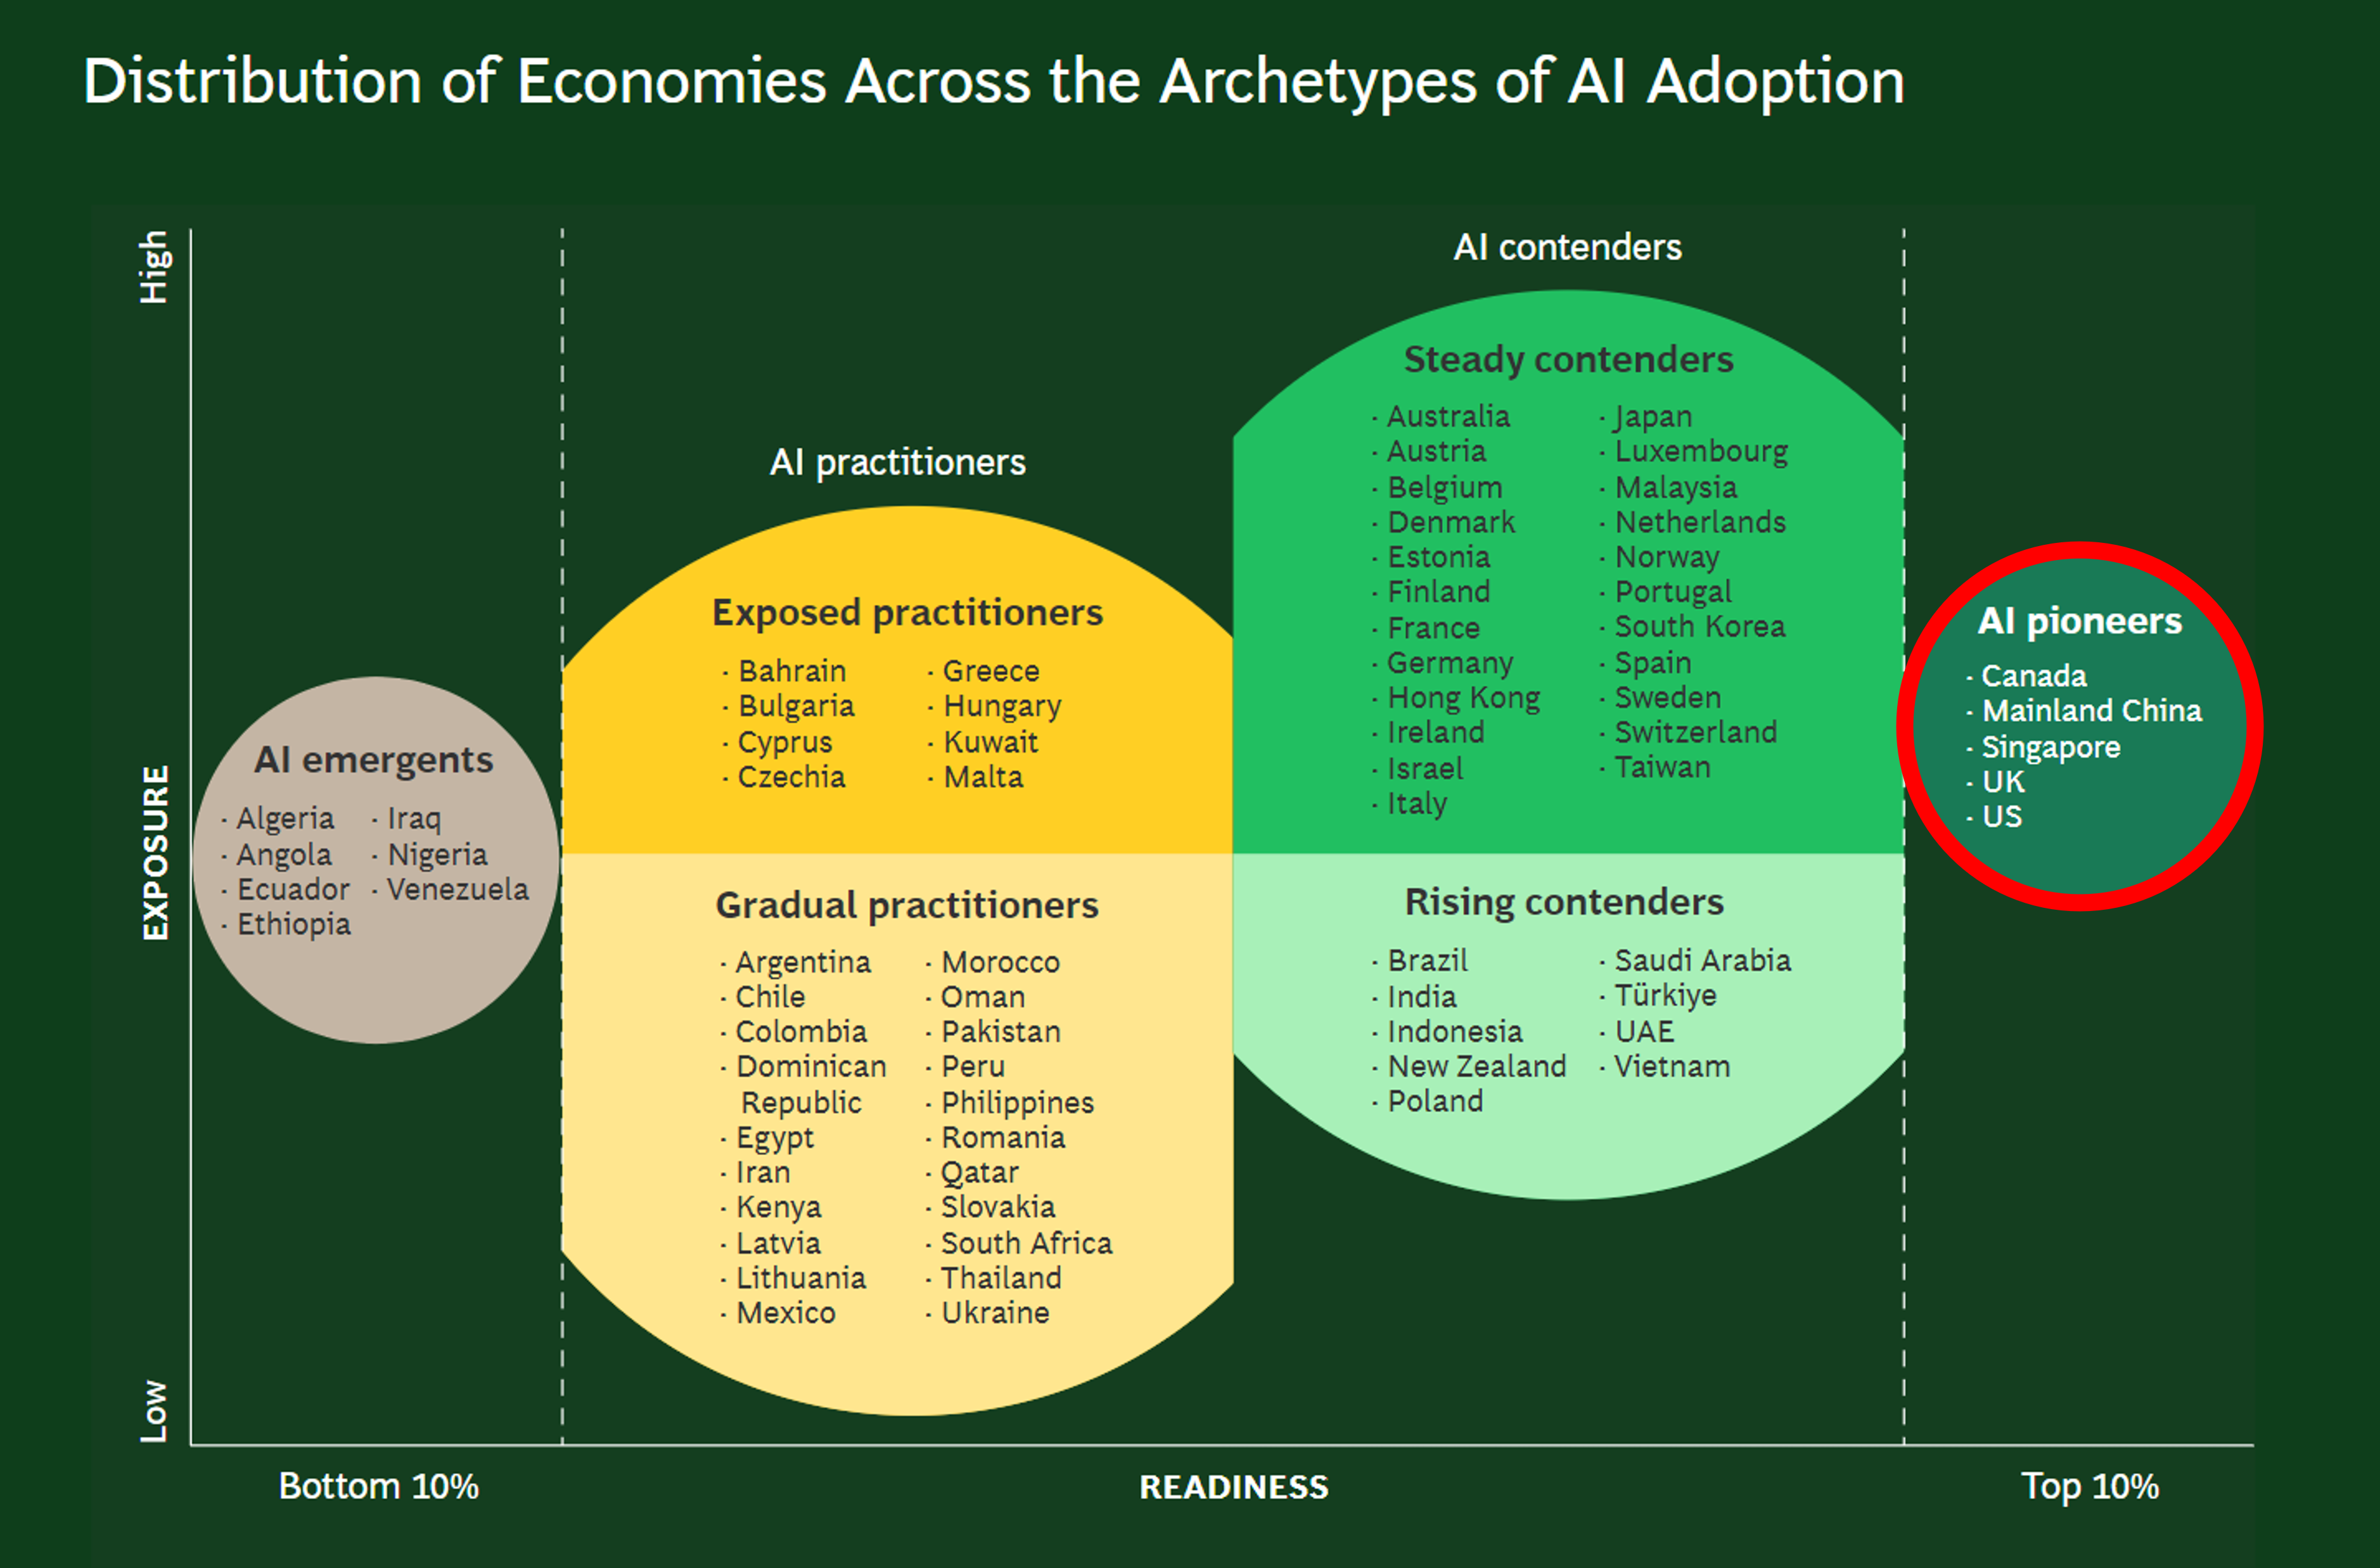

In [39]:
import base64
from IPython.display import Image, display

display(Image(data="assets/AI_Pioneers.png"))  # Display the image